# Transfer Learning

#### Neural Network for Suggestive CAD

--------------------------------------------------------------------------------------------------------------------------------

    Import packages

In [1]:
import numpy as np
import collections
#from tensorflow.python.framework import dtypes

from os import listdir
import os
from os.path import isfile, join
import numpy as np
import cv2

import matplotlib.pylab as plt
%matplotlib inline

from __future__ import division
from __future__ import print_function

import argparse
import sys

import glob
import param
import time

#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
import IPython.display as display

import tensorflow as tf

#import pydotplus as pydot
#import graphviz



# KERAS IMPORTS
import keras
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization 
from keras.layers.advanced_activations import LeakyReLU
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import History 

#SKLEARN
from sklearn.metrics import classification_report

C:\Users\TempUser\Anaconda3\envs\CPU_tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
###From https://gist.github.com/ambodi/408301bc5bc07bc5afa8748513ab9477#file-dataset-py-L74

In [4]:
###Data from  https://www.kaggle.com/c/dogs-vs-cats/data

## Saving raw data to npy

#### Load data

In [2]:
#path to directory
path_train = 'raw_data/train/'
path_test = 'raw_data/test/'
path_val = 'raw_data/val/'

img_size= 100

#get folder names
def directory_scan(path):
    dirlist = [ item for item in os.listdir(path) if os.path.isdir(os.path.join(path, item)) ]
    return dirlist

#build labels and image arrays, resize image to 100*100
def read_images_in_folder(dirlist, path):
    images=[]
    labels = []
    count = 0
    for i in range(len(dirlist)):
        image_stack = []
        for img in glob.glob(path+dirlist[i]+'/*jpg'):
            count=count+1
            labels.append(dirlist[i])
            IMG = cv2.imread(img)
            #RGB to grey scale
            #IMG_2= cv2.cvtColor( IMG, cv2.COLOR_RGB2GRAY )
            #resize to 100*100
            im_resize = cv2.resize(IMG, (img_size, img_size), 3)
            images.append(im_resize)
        #np_images = np.array(image_stack)
        
    return images, labels, count

In [17]:
if __name__ == '__main__':
    dirlist_train = directory_scan(path_train)
    images_train,labels_train,count_train = read_images_in_folder(dirlist_train, path_train)
    dirlist_test = directory_scan(path_test)
    images_test,labels_test,count_test = read_images_in_folder(dirlist_test, path_test)

if __name__ == '__main__':
    dirlist_val = directory_scan(path_val)
    images_val,labels_val,count_val= read_images_in_folder(dirlist_val, path_val)

np.save('npy-color/images_val',images_val)
np.save('npy-color/labels_val',labels_val)

#save to file
np.save('npy-color/images_train',images_train)
np.save('npy-color/labels_train',labels_train)
np.save('npy-color/images_test',images_test)
np.save('npy-color/labels_test',labels_test)

print('There are '+ str(count_train) +' training images')
print('There are '+ str(count_test) +' testing images')

nb_img_train = count_train
nb_img_test = count_test

There are 15008 training images
There are 1120 testing images


#### Load NPY data

In [2]:
#LOAD TRAIN
#load images
train_images = np.load('npy-color/images_train.npy')

#load labels
train_labels = np.load('npy-color/labels_train.npy')

#LOAD TEST
#load images
test_images = np.load('npy-color/images_test.npy')


#load labels
test_labels = np.load('npy-color/labels_test.npy')

#LOAD VALIDATION
#load images
val_images = np.load('npy-color/images_val.npy')

#load labels
val_labels = np.load('npy-color/labels_val.npy')

img_size=100

bed


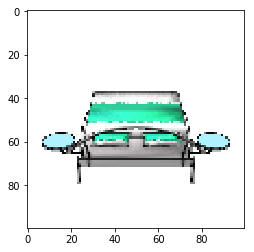

In [3]:
index = 300
print(train_labels[index])
plt.imshow(train_images[index])

In [4]:
path_train = 'raw_data/train/'
path_test = 'raw_data/test/'
path_val = 'raw_data/val/'
img_size= 100

#get folder names
def directory_scan(path):
    dirlist = [ item for item in os.listdir(path) if os.path.isdir(os.path.join(path, item)) ]
    return dirlist

dirlist_train = directory_scan(path_train)
dirlist_test = directory_scan(path_test)
dirlist_val = directory_scan(path_val)

nb_img_train = len(train_images)
nb_img_test = len(test_images)
nb_img_val = len(val_images)

In [5]:
#prepare and reshape testing/training sets
#img_size = 100
#nb_img_train = 1400
#nb_img_test = 40

train_img = train_images.reshape([-1,img_size,img_size,3])
train_img = train_img.astype('float32') / 255

test_img = test_images.reshape([-1,img_size,img_size,3])
test_img = test_img.astype('float32') / 255

val_img = val_images.reshape([-1,img_size,img_size,3])
val_img = val_img.astype('float32') / 255

#### One Hot Encoding of Labels

In [6]:
#LABEL ONE HOT ENCODING
#Training
k=0
for i in range(len(dirlist_train)):
    for j in range(len(train_labels)):
        if(train_labels[j]==dirlist_train[i]):
            train_labels[j]=k
    k=k+1

#Testing
m=0
for l in range(len(dirlist_test)):
    for h in range(len(test_labels)):
        if(test_labels[h]==dirlist_test[l]):
            test_labels[h]=m
    m=m+1
    
#Validation
g=0
for l in range(len(dirlist_val)):
    for h in range(len(val_labels)):
        if(val_labels[h]==dirlist_val[l]):
            val_labels[h]=g
    g=g+1

In [7]:
train_lab= to_categorical(train_labels)
test_lab = to_categorical(test_labels)
val_lab = to_categorical(val_labels)

In [8]:
def Plot_accuracy(train_acc, val_acc, Title):
    x = [i for i in range(0, len(train_acc))]
    y= train_acc
    plt.plot(x,y)
    
    x = [i for i in range(0, len(val_acc))]
    y= val_acc
    plt.plot(x,y)
    
    plt.ylabel('Accuracy')
    plt.xlabel('Steps')
    plt.xticks(x)
    plt.ylim(ymax=1)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.grid(True)
    plt.title(Title)
    plt.show()
    
def Plot_Loss(train_loss, val_loss, Title):
    x = [i for i in range(0, len(val_loss))]
    y= train_loss
    plt.plot(x,y)

    x = [i for i in range(0, len(val_loss))]
    y= val_loss
    plt.plot(x,y)
    
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.xticks(x)
    plt.ylim(ymax=2)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.grid(True)
    plt.title(Title)
    plt.show()

--------------------------------------------------------------------------------------------------------------------------------

## VGG

https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/

    Import VGG pretrained network

In [20]:
from keras import applications

In [21]:
conv_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

In [22]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

    Preprocess dataset with VGG model

In [ ]:
#gets feature maps for dataset based on inital VGG model
#    >>from training set to feature map
start = time.time()

train_features = conv_base.predict(train_img)
#train_features = np.reshape(train_features, (len(train_img), 3 * 3 * 512))

stop = time.time()
print("Execution time = " + str(int(((stop-start)-(stop-start)%60)/60)) +" min "+str((stop-start)%60)+" sec")

In [ ]:
#Save feature maps to file
np.save('train_features/', train_features)

In [30]:
#reshape feature maps to match output of VGG model with input of additional layers
train_features_reshaped = np.reshape(train_features, (len(train_img), 3 * 3 * 512))

In [36]:
#Save feature maps to file
np.save('train_features/train_features', train_features_reshaped)

In [23]:
#loads feature map from file
train_features_ = np.load('train_features/train_features.npy')

In [25]:
train_features_.shape

(15008, 4608)

In [13]:
#gets feature maps for dataset based on inital VGG model
#    >>from training set to feature map
start = time.time()

val_features = conv_base.predict(val_img)
#train_features = np.reshape(train_features, (len(train_img), 3 * 3 * 512))

stop = time.time()
print("Execution time = " + str(int(((stop-start)-(stop-start)%60)/60)) +" min "+str((stop-start)%60)+" sec")

Execution time = 1 min 29.839893341064453 sec


In [14]:
val_features = np.reshape(val_features, (len(val_img), 3 * 3 * 512))

    Additional network

In [57]:
model = models.Sequential()
model.add(layers.Dense(400, activation='relu', input_dim=3 * 3 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(400, activation='relu', input_dim=3 * 3 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(400, activation='relu', input_dim=3 * 3 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(300, activation='relu', input_dim=3 * 3 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(200, activation='relu', input_dim=3 * 3 * 512))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(len(dirlist_train), activation='softmax'))

In [58]:
history= History()

model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
 
training = model.fit(train_features_,
                    train_lab,
                    epochs=50,
                    batch_size=250,
                    validation_data=(val_features,val_lab), callbacks=[history])

Train on 15008 samples, validate on 1120 samples
Epoch 1/50
15008/15008 [==============================] - 5s 315us/step - loss: 1.9647 - acc: 0.2293 - val_loss: 1.8019 - val_acc: 0.3214
Epoch 2/50
15008/15008 [==============================] - 4s 273us/step - loss: 1.5425 - acc: 0.4090 - val_loss: 1.4481 - val_acc: 0.4482
Epoch 3/50
15008/15008 [==============================] - 4s 267us/step - loss: 1.2665 - acc: 0.5318 - val_loss: 1.2998 - val_acc: 0.4795
Epoch 4/50
15008/15008 [==============================] - 4s 261us/step - loss: 1.1160 - acc: 0.5995 - val_loss: 1.2081 - val_acc: 0.5545
Epoch 5/50
15008/15008 [==============================] - 4s 263us/step - loss: 0.9873 - acc: 0.6563 - val_loss: 1.1554 - val_acc: 0.5616
Epoch 6/50
15008/15008 [==============================] - 4s 272us/step - loss: 0.8967 - acc: 0.6955 - val_loss: 1.0741 - val_acc: 0.6036
Epoch 7/50
15008/15008 [==============================] - 4s 261us/step - loss: 0.8043 - acc: 0.7233 - val_loss: 1.1642 - v

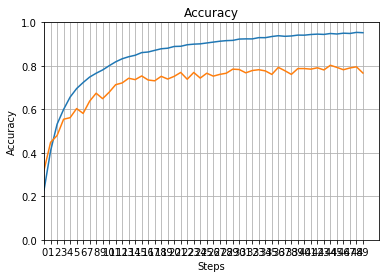

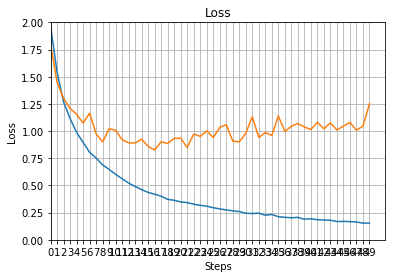

In [59]:
Plot_accuracy(history.history['acc'], history.history['val_acc'],"Accuracy")

Plot_Loss(history.history['loss'],history.history['val_loss'], "Loss")

    Test

In [97]:
predictions = model.predict(val_features)

#one hot encoding
for i in range(len(predictions)):
    length = len(predictions[i])
    index = np.argmax(predictions[i])
    predictions[i][index] = 1
    for j in range(length):
        if(j != index):
            predictions[i][j] = 0

In [98]:
print(classification_report(test_lab, predictions, target_names = dirlist_train))

             precision    recall  f1-score   support

        bed       0.83      0.71      0.77       150
      bench       0.85      0.56      0.67        70
    cabinet       0.81      0.78      0.79       150
      chair       0.86      0.94      0.90       150
      couch       0.68      0.88      0.77       150
       lamp       0.81      0.79      0.80       150
      plant       0.95      0.91      0.93       150
      table       0.80      0.83      0.81       150

avg / total       0.82      0.82      0.81      1120



------------------------------------------------------------------------------------------------------------------------------

# ResNet

In [9]:
from keras import applications
conv_base_resnet = applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(197, 197, 3))

In [10]:
conv_base_resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 99, 99, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 99, 99, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 99, 99, 64)   0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [20]:
train_img_197_197 = []

In [21]:
for i in range(len(train_img)):
    img = cv2.resize(train_img[i], (197, 197))
    train_img_197_197.append(img)

In [22]:
train_img_197 = np.array(train_img_197_197)

In [25]:
#gets feature maps for dataset based on inital VGG model
#    >>from training set to feature map
start = time.time()

train_features_1 = conv_base_resnet.predict(train_img_197)
#train_features = np.reshape(train_features, (len(train_img), 3 * 3 * 512))

stop = time.time()
print("Execution time = " + str(int(((stop-start)-(stop-start)%60)/60)) +" min "+str((stop-start)%60)+" sec")

Execution time = 73 min 45.37593460083008 sec


In [ ]:
train_features_1 = train_features_1.reshape(len(train_img),2048)

In [26]:
#Save feature maps to file
np.save('train_features_resnet/train_features_resnet', train_features_1)

In [12]:
#loads feature map from file
train_features_resnet = np.load('train_features_resnet/train_features_resnet.npy')

In [13]:
train_features_resnet.shape

(15008, 1, 1, 2048)

In [14]:
train_features_1 = train_features_resnet.reshape(len(train_img),2048)

In [33]:
val_img_197_197 = []

In [34]:
for i in range(len(val_img)):
    img = cv2.resize(val_img[i], (197, 197))
    val_img_197_197.append(img)

In [35]:
val_img_197 = np.array(val_img_197_197)

In [36]:
#gets feature maps for dataset based on inital VGG model
#    >>from training set to feature map
start = time.time()

val_features_resnet = conv_base_resnet.predict(val_img_197)
#train_features = np.reshape(train_features, (len(train_img), 3 * 3 * 512))

stop = time.time()
print("Execution time = " + str(int(((stop-start)-(stop-start)%60)/60)) +" min "+str((stop-start)%60)+" sec")

Execution time = 5 min 14.945082187652588 sec


In [37]:
#Save feature maps to file
np.save('train_features_resnet/val_features_resnet', val_features_resnet)

In [11]:
#loads feature map from file
val_features_1 = np.load('train_features_resnet/val_features_resnet.npy')

In [15]:
val_features_1 = val_features_1.reshape(len(val_img),2048)

In [16]:
model_resnet = models.Sequential()
model_resnet.add(layers.Dense(400, activation='relu', input_dim=1 * 1 * 2048))
model_resnet.add(layers.Dropout(0.5))
model_resnet.add(layers.Dense(400, activation='relu'))
model_resnet.add(layers.Dropout(0.2))

model_resnet.add(layers.Dense(len(dirlist_train), activation='softmax'))

In [17]:
start = time.time()
history= History()

model_resnet.compile(optimizer=keras.optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
 
training = model_resnet.fit(train_features_1,
                    train_lab,
                    epochs=5000,
                    batch_size=500,
                    validation_data=(val_features_1,val_lab), callbacks=[history])

stop = time.time()
print("Execution time = " + str(int(((stop-start)-(stop-start)%60)/60)) +" min "+str((stop-start)%60)+" sec")

Train on 15008 samples, validate on 1120 samples
Epoch 1/5000
15008/15008 [==============================] - 2s 138us/step - loss: 1.9735 - acc: 0.2241 - val_loss: 2.0911 - val_acc: 0.2920
Epoch 2/5000
15008/15008 [==============================] - 1s 92us/step - loss: 1.8617 - acc: 0.2997 - val_loss: 2.1049 - val_acc: 0.1491
Epoch 3/5000
15008/15008 [==============================] - 2s 105us/step - loss: 1.7922 - acc: 0.3411 - val_loss: 1.9186 - val_acc: 0.2321
Epoch 4/5000
15008/15008 [==============================] - 1s 98us/step - loss: 1.7239 - acc: 0.3766 - val_loss: 1.9488 - val_acc: 0.2509
Epoch 5/5000
15008/15008 [==============================] - 1s 91us/step - loss: 1.6803 - acc: 0.3959 - val_loss: 1.8276 - val_acc: 0.2937
Epoch 6/5000
15008/15008 [==============================] - 1s 91us/step - loss: 1.6364 - acc: 0.4113 - val_loss: 1.9570 - val_acc: 0.2268
Epoch 7/5000
15008/15008 [==============================] - 1s 92us/step - loss: 1.6149 - acc: 0.4225 - val_loss: 1

15008/15008 [==============================] - 1s 94us/step - loss: 1.1887 - acc: 0.5758 - val_loss: 1.8064 - val_acc: 0.4634
Epoch 60/5000
15008/15008 [==============================] - 1s 90us/step - loss: 1.1890 - acc: 0.5754 - val_loss: 1.6095 - val_acc: 0.4393
Epoch 61/5000
15008/15008 [==============================] - 1s 85us/step - loss: 1.1898 - acc: 0.5752 - val_loss: 2.0592 - val_acc: 0.3375
Epoch 62/5000
15008/15008 [==============================] - 1s 84us/step - loss: 1.2011 - acc: 0.5732 - val_loss: 2.1883 - val_acc: 0.3759
Epoch 63/5000
15008/15008 [==============================] - 1s 83us/step - loss: 1.1838 - acc: 0.5780 - val_loss: 1.5035 - val_acc: 0.4339
Epoch 64/5000
15008/15008 [==============================] - 1s 84us/step - loss: 1.1854 - acc: 0.5750 - val_loss: 1.7409 - val_acc: 0.4196
Epoch 65/5000
15008/15008 [==============================] - 1s 84us/step - loss: 1.1873 - acc: 0.5723 - val_loss: 1.4975 - val_acc: 0.4491
Epoch 66/5000
15008/15008 [=======

15008/15008 [==============================] - 1s 84us/step - loss: 1.0771 - acc: 0.6144 - val_loss: 1.8537 - val_acc: 0.4438
Epoch 118/5000
15008/15008 [==============================] - 1s 83us/step - loss: 1.0650 - acc: 0.6187 - val_loss: 1.8347 - val_acc: 0.4955
Epoch 119/5000
15008/15008 [==============================] - 1s 84us/step - loss: 1.0669 - acc: 0.6215 - val_loss: 1.4429 - val_acc: 0.5179
Epoch 120/5000
15008/15008 [==============================] - 1s 83us/step - loss: 1.0580 - acc: 0.6226 - val_loss: 1.6130 - val_acc: 0.4848
Epoch 121/5000
15008/15008 [==============================] - 1s 91us/step - loss: 1.0803 - acc: 0.6195 - val_loss: 1.8705 - val_acc: 0.3339
Epoch 122/5000
15008/15008 [==============================] - 1s 90us/step - loss: 1.0677 - acc: 0.6194 - val_loss: 1.3920 - val_acc: 0.5286
Epoch 123/5000
15008/15008 [==============================] - 1s 84us/step - loss: 1.0547 - acc: 0.6220 - val_loss: 1.8589 - val_acc: 0.4241
Epoch 124/5000
15008/15008 [

15008/15008 [==============================] - 1s 84us/step - loss: 0.9973 - acc: 0.6466 - val_loss: 1.3024 - val_acc: 0.5571
Epoch 176/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.9842 - acc: 0.6474 - val_loss: 1.7923 - val_acc: 0.4634
Epoch 177/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.9980 - acc: 0.6442 - val_loss: 1.5702 - val_acc: 0.5232
Epoch 178/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.9801 - acc: 0.6496 - val_loss: 1.7205 - val_acc: 0.4741
Epoch 179/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.9949 - acc: 0.6475 - val_loss: 1.4275 - val_acc: 0.5027
Epoch 180/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.9742 - acc: 0.6501 - val_loss: 1.6725 - val_acc: 0.4875
Epoch 181/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.9974 - acc: 0.6424 - val_loss: 1.2750 - val_acc: 0.5420
Epoch 182/5000
15008/15008 [

15008/15008 [==============================] - 1s 92us/step - loss: 0.9575 - acc: 0.6628 - val_loss: 1.4846 - val_acc: 0.5241
Epoch 234/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.9257 - acc: 0.6702 - val_loss: 1.4460 - val_acc: 0.5268
Epoch 235/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.9423 - acc: 0.6700 - val_loss: 1.1760 - val_acc: 0.5777
Epoch 236/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.9377 - acc: 0.6634 - val_loss: 1.4894 - val_acc: 0.4768
Epoch 237/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.9388 - acc: 0.6656 - val_loss: 1.3986 - val_acc: 0.5536
Epoch 238/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.9353 - acc: 0.6712 - val_loss: 1.1409 - val_acc: 0.6187
Epoch 239/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.9318 - acc: 0.6662 - val_loss: 1.8687 - val_acc: 0.4491
Epoch 240/5000
15008/15008 [

15008/15008 [==============================] - 1s 88us/step - loss: 0.8776 - acc: 0.6852 - val_loss: 1.5604 - val_acc: 0.5437
Epoch 292/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.8900 - acc: 0.6812 - val_loss: 1.4306 - val_acc: 0.4839
Epoch 293/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.8830 - acc: 0.6834 - val_loss: 1.6563 - val_acc: 0.4313
Epoch 294/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.8856 - acc: 0.6846 - val_loss: 1.4399 - val_acc: 0.5357
Epoch 295/5000
15008/15008 [==============================] - 1s 98us/step - loss: 0.8766 - acc: 0.6883 - val_loss: 1.3102 - val_acc: 0.5732
Epoch 296/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.8703 - acc: 0.6912 - val_loss: 1.6433 - val_acc: 0.4813
Epoch 297/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.8855 - acc: 0.6852 - val_loss: 1.3676 - val_acc: 0.5295
Epoch 298/5000
15008/15008 [

15008/15008 [==============================] - 1s 85us/step - loss: 0.8371 - acc: 0.7029 - val_loss: 1.3476 - val_acc: 0.5571
Epoch 350/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.8364 - acc: 0.7058 - val_loss: 1.5433 - val_acc: 0.5375
Epoch 351/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.8457 - acc: 0.7040 - val_loss: 1.1323 - val_acc: 0.6063
Epoch 352/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.8334 - acc: 0.7010 - val_loss: 1.4829 - val_acc: 0.5116
Epoch 353/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.8382 - acc: 0.6980 - val_loss: 1.4124 - val_acc: 0.5464
Epoch 354/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.8392 - acc: 0.7008 - val_loss: 1.4378 - val_acc: 0.5134
Epoch 355/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.8512 - acc: 0.6958 - val_loss: 1.8038 - val_acc: 0.4500
Epoch 356/5000
15008/15008 [

15008/15008 [==============================] - 1s 84us/step - loss: 0.8148 - acc: 0.7111 - val_loss: 1.3829 - val_acc: 0.5634
Epoch 408/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.8174 - acc: 0.7086 - val_loss: 1.1807 - val_acc: 0.6375
Epoch 409/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.7911 - acc: 0.7183 - val_loss: 1.5290 - val_acc: 0.5286
Epoch 410/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.7992 - acc: 0.7162 - val_loss: 1.3519 - val_acc: 0.5723
Epoch 411/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.8050 - acc: 0.7129 - val_loss: 1.6025 - val_acc: 0.5107
Epoch 412/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.8115 - acc: 0.7133 - val_loss: 1.7170 - val_acc: 0.4991
Epoch 413/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.8106 - acc: 0.7135 - val_loss: 1.5382 - val_acc: 0.5518
Epoch 414/5000
15008/15008 [

15008/15008 [==============================] - 1s 84us/step - loss: 0.7824 - acc: 0.7186 - val_loss: 1.3507 - val_acc: 0.6214
Epoch 466/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.7655 - acc: 0.7263 - val_loss: 1.6956 - val_acc: 0.5161
Epoch 467/5000
15008/15008 [==============================] - 1s 90us/step - loss: 0.7812 - acc: 0.7282 - val_loss: 1.3685 - val_acc: 0.5866
Epoch 468/5000
15008/15008 [==============================] - 1s 90us/step - loss: 0.7736 - acc: 0.7246 - val_loss: 1.4021 - val_acc: 0.5518
Epoch 469/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.7823 - acc: 0.7236 - val_loss: 1.3178 - val_acc: 0.5750
Epoch 470/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.7822 - acc: 0.7225 - val_loss: 1.5462 - val_acc: 0.5375
Epoch 471/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.7778 - acc: 0.7223 - val_loss: 1.4470 - val_acc: 0.5250
Epoch 472/5000
15008/15008 [

15008/15008 [==============================] - 1s 84us/step - loss: 0.7585 - acc: 0.7283 - val_loss: 1.2974 - val_acc: 0.5884
Epoch 524/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.7493 - acc: 0.7342 - val_loss: 1.3941 - val_acc: 0.5857
Epoch 525/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.7529 - acc: 0.7309 - val_loss: 1.5632 - val_acc: 0.5089
Epoch 526/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.7577 - acc: 0.7320 - val_loss: 1.9953 - val_acc: 0.4964
Epoch 527/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.7804 - acc: 0.7268 - val_loss: 1.3120 - val_acc: 0.5821
Epoch 528/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.7355 - acc: 0.7371 - val_loss: 1.1424 - val_acc: 0.6321
Epoch 529/5000
15008/15008 [==============================] - 1s 88us/step - loss: 0.7346 - acc: 0.7375 - val_loss: 1.2265 - val_acc: 0.5973
Epoch 530/5000
15008/15008 [

15008/15008 [==============================] - 1s 85us/step - loss: 0.7328 - acc: 0.7363 - val_loss: 1.2829 - val_acc: 0.5571
Epoch 582/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.7254 - acc: 0.7400 - val_loss: 1.3110 - val_acc: 0.5705
Epoch 583/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.7407 - acc: 0.7370 - val_loss: 1.4561 - val_acc: 0.5652
Epoch 584/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.7269 - acc: 0.7425 - val_loss: 1.3013 - val_acc: 0.5723
Epoch 585/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.7261 - acc: 0.7394 - val_loss: 1.0935 - val_acc: 0.6232
Epoch 586/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.7248 - acc: 0.7399 - val_loss: 1.4006 - val_acc: 0.5679
Epoch 587/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.7156 - acc: 0.7435 - val_loss: 1.2272 - val_acc: 0.6205
Epoch 588/5000
15008/15008 [

15008/15008 [==============================] - 1s 83us/step - loss: 0.7018 - acc: 0.7488 - val_loss: 1.3021 - val_acc: 0.5911
Epoch 640/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.7057 - acc: 0.7482 - val_loss: 1.6931 - val_acc: 0.5527
Epoch 641/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.7076 - acc: 0.7477 - val_loss: 1.3071 - val_acc: 0.6143
Epoch 642/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.6974 - acc: 0.7508 - val_loss: 1.3005 - val_acc: 0.5759
Epoch 643/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.7089 - acc: 0.7479 - val_loss: 1.4503 - val_acc: 0.5812
Epoch 644/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.7054 - acc: 0.7505 - val_loss: 1.1958 - val_acc: 0.6134
Epoch 645/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.7076 - acc: 0.7439 - val_loss: 1.3935 - val_acc: 0.5688
Epoch 646/5000
15008/15008 [

15008/15008 [==============================] - 1s 84us/step - loss: 0.6825 - acc: 0.7577 - val_loss: 1.5874 - val_acc: 0.4723
Epoch 698/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.6916 - acc: 0.7494 - val_loss: 1.2347 - val_acc: 0.5875
Epoch 699/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.7046 - acc: 0.7445 - val_loss: 1.1855 - val_acc: 0.6312
Epoch 700/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6671 - acc: 0.7629 - val_loss: 1.3059 - val_acc: 0.5955
Epoch 701/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6734 - acc: 0.7610 - val_loss: 1.4908 - val_acc: 0.5875
Epoch 702/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.6873 - acc: 0.7537 - val_loss: 1.2129 - val_acc: 0.6321
Epoch 703/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.6758 - acc: 0.7586 - val_loss: 1.0749 - val_acc: 0.6768
Epoch 704/5000
15008/15008 [

15008/15008 [==============================] - 1s 89us/step - loss: 0.6620 - acc: 0.7669 - val_loss: 1.1530 - val_acc: 0.6000
Epoch 756/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.6745 - acc: 0.7588 - val_loss: 1.2112 - val_acc: 0.6330
Epoch 757/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.6738 - acc: 0.7555 - val_loss: 1.2116 - val_acc: 0.5991
Epoch 758/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6740 - acc: 0.7601 - val_loss: 1.6182 - val_acc: 0.4768
Epoch 759/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.6719 - acc: 0.7639 - val_loss: 1.6172 - val_acc: 0.5223
Epoch 760/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6750 - acc: 0.7612 - val_loss: 1.4893 - val_acc: 0.5884
Epoch 761/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.6752 - acc: 0.7573 - val_loss: 1.5368 - val_acc: 0.5670
Epoch 762/5000
15008/15008 [

15008/15008 [==============================] - 1s 83us/step - loss: 0.6369 - acc: 0.7712 - val_loss: 1.5904 - val_acc: 0.5732
Epoch 814/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6455 - acc: 0.7738 - val_loss: 1.2547 - val_acc: 0.5929
Epoch 815/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6411 - acc: 0.7731 - val_loss: 1.2227 - val_acc: 0.6375
Epoch 816/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.6483 - acc: 0.7699 - val_loss: 1.2928 - val_acc: 0.6107
Epoch 817/5000
15008/15008 [==============================] - 1s 92us/step - loss: 0.6599 - acc: 0.7631 - val_loss: 1.3967 - val_acc: 0.5804
Epoch 818/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.6487 - acc: 0.7662 - val_loss: 1.3216 - val_acc: 0.5723
Epoch 819/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6320 - acc: 0.7741 - val_loss: 1.4949 - val_acc: 0.5562
Epoch 820/5000
15008/15008 [

15008/15008 [==============================] - 1s 84us/step - loss: 0.6307 - acc: 0.7735 - val_loss: 1.3492 - val_acc: 0.6000
Epoch 872/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6314 - acc: 0.7767 - val_loss: 1.2554 - val_acc: 0.6312
Epoch 873/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6378 - acc: 0.7749 - val_loss: 1.5779 - val_acc: 0.4920
Epoch 874/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.6380 - acc: 0.7759 - val_loss: 1.3772 - val_acc: 0.6348
Epoch 875/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6393 - acc: 0.7777 - val_loss: 1.2965 - val_acc: 0.6348
Epoch 876/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6259 - acc: 0.7771 - val_loss: 1.0799 - val_acc: 0.6643
Epoch 877/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.6321 - acc: 0.7736 - val_loss: 1.2428 - val_acc: 0.5875
Epoch 878/5000
15008/15008 [

15008/15008 [==============================] - 1s 91us/step - loss: 0.6164 - acc: 0.7782 - val_loss: 1.3089 - val_acc: 0.6205
Epoch 930/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.6125 - acc: 0.7820 - val_loss: 1.1991 - val_acc: 0.6304
Epoch 931/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6077 - acc: 0.7857 - val_loss: 1.4995 - val_acc: 0.5625
Epoch 932/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6206 - acc: 0.7830 - val_loss: 1.1894 - val_acc: 0.6455
Epoch 933/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5957 - acc: 0.7854 - val_loss: 1.2146 - val_acc: 0.6125
Epoch 934/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6055 - acc: 0.7822 - val_loss: 1.2912 - val_acc: 0.6063
Epoch 935/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6154 - acc: 0.7813 - val_loss: 1.3952 - val_acc: 0.5857
Epoch 936/5000
15008/15008 [

15008/15008 [==============================] - 1s 84us/step - loss: 0.6211 - acc: 0.7791 - val_loss: 1.5987 - val_acc: 0.5509
Epoch 988/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5870 - acc: 0.7916 - val_loss: 1.4808 - val_acc: 0.5804
Epoch 989/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6130 - acc: 0.7848 - val_loss: 1.3156 - val_acc: 0.6089
Epoch 990/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5974 - acc: 0.7908 - val_loss: 1.1584 - val_acc: 0.6036
Epoch 991/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.6089 - acc: 0.7854 - val_loss: 1.2963 - val_acc: 0.6125
Epoch 992/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.6093 - acc: 0.7827 - val_loss: 1.2128 - val_acc: 0.6018
Epoch 993/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.5866 - acc: 0.7926 - val_loss: 1.2435 - val_acc: 0.6357
Epoch 994/5000
15008/15008 [

Epoch 1045/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5901 - acc: 0.7876 - val_loss: 1.2364 - val_acc: 0.6054
Epoch 1046/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6046 - acc: 0.7839 - val_loss: 1.4461 - val_acc: 0.5893
Epoch 1047/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5895 - acc: 0.7896 - val_loss: 1.4264 - val_acc: 0.6063
Epoch 1048/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5941 - acc: 0.7900 - val_loss: 1.1762 - val_acc: 0.6348
Epoch 1049/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.5770 - acc: 0.7890 - val_loss: 1.3719 - val_acc: 0.6071
Epoch 1050/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.6012 - acc: 0.7860 - val_loss: 1.1346 - val_acc: 0.6670
Epoch 1051/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.5841 - acc: 0.7914 - val_loss: 1.2813 - val_acc: 0.6393
Epoch 

15008/15008 [==============================] - 1s 83us/step - loss: 0.5710 - acc: 0.7971 - val_loss: 1.2401 - val_acc: 0.6732
Epoch 1103/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5711 - acc: 0.7950 - val_loss: 1.1989 - val_acc: 0.6518
Epoch 1104/5000
15008/15008 [==============================] - 1s 90us/step - loss: 0.5859 - acc: 0.7915 - val_loss: 1.4477 - val_acc: 0.5946
Epoch 1105/5000
15008/15008 [==============================] - 1s 88us/step - loss: 0.5670 - acc: 0.8010 - val_loss: 1.4643 - val_acc: 0.6089
Epoch 1106/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.5729 - acc: 0.7970 - val_loss: 1.2369 - val_acc: 0.6688
Epoch 1107/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.5623 - acc: 0.7965 - val_loss: 1.1113 - val_acc: 0.6839
Epoch 1108/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.5815 - acc: 0.7948 - val_loss: 1.4735 - val_acc: 0.6018
Epoch 1109/5000
15008/

Epoch 1160/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5703 - acc: 0.7976 - val_loss: 1.3722 - val_acc: 0.5991
Epoch 1161/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5798 - acc: 0.7950 - val_loss: 1.1100 - val_acc: 0.6580
Epoch 1162/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.5474 - acc: 0.8061 - val_loss: 1.3287 - val_acc: 0.6134
Epoch 1163/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.5572 - acc: 0.7990 - val_loss: 1.2695 - val_acc: 0.6429
Epoch 1164/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5550 - acc: 0.8019 - val_loss: 1.4660 - val_acc: 0.5812
Epoch 1165/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5720 - acc: 0.7957 - val_loss: 1.1914 - val_acc: 0.6509
Epoch 1166/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.5640 - acc: 0.7988 - val_loss: 1.4482 - val_acc: 0.6170
Epoch 

15008/15008 [==============================] - 1s 91us/step - loss: 0.5492 - acc: 0.8037 - val_loss: 1.1796 - val_acc: 0.6259
Epoch 1218/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.5636 - acc: 0.8016 - val_loss: 1.3647 - val_acc: 0.6304
Epoch 1219/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5535 - acc: 0.8044 - val_loss: 1.2619 - val_acc: 0.6536
Epoch 1220/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5385 - acc: 0.8063 - val_loss: 1.4565 - val_acc: 0.5723
Epoch 1221/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5640 - acc: 0.7997 - val_loss: 1.7300 - val_acc: 0.5357
Epoch 1222/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5743 - acc: 0.8000 - val_loss: 1.2903 - val_acc: 0.6411
Epoch 1223/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5518 - acc: 0.8026 - val_loss: 1.4133 - val_acc: 0.5929
Epoch 1224/5000
15008/

Epoch 1275/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5351 - acc: 0.8096 - val_loss: 1.4555 - val_acc: 0.6250
Epoch 1276/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5365 - acc: 0.8082 - val_loss: 1.3995 - val_acc: 0.6277
Epoch 1277/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5375 - acc: 0.8087 - val_loss: 1.3678 - val_acc: 0.6080
Epoch 1278/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5463 - acc: 0.8098 - val_loss: 1.2858 - val_acc: 0.6134
Epoch 1279/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.5643 - acc: 0.8017 - val_loss: 1.2054 - val_acc: 0.6527
Epoch 1280/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.5460 - acc: 0.8068 - val_loss: 1.4680 - val_acc: 0.5705
Epoch 1281/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5510 - acc: 0.8050 - val_loss: 1.4935 - val_acc: 0.6045
Epoch 

15008/15008 [==============================] - 1s 85us/step - loss: 0.5363 - acc: 0.8143 - val_loss: 1.7688 - val_acc: 0.5455
Epoch 1333/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.5366 - acc: 0.8128 - val_loss: 2.0270 - val_acc: 0.5250
Epoch 1334/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.5429 - acc: 0.8087 - val_loss: 1.8330 - val_acc: 0.5464
Epoch 1335/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.5526 - acc: 0.8082 - val_loss: 1.2116 - val_acc: 0.6500
Epoch 1336/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.5350 - acc: 0.8113 - val_loss: 1.2240 - val_acc: 0.6250
Epoch 1337/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.5456 - acc: 0.8024 - val_loss: 1.0947 - val_acc: 0.6384
Epoch 1338/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.5383 - acc: 0.8068 - val_loss: 1.2810 - val_acc: 0.6277
Epoch 1339/5000
15008/

Epoch 1390/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5235 - acc: 0.8145 - val_loss: 1.1301 - val_acc: 0.6786
Epoch 1391/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.5036 - acc: 0.8202 - val_loss: 1.2508 - val_acc: 0.6473
Epoch 1392/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.5271 - acc: 0.8086 - val_loss: 1.1741 - val_acc: 0.6455
Epoch 1393/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5268 - acc: 0.8072 - val_loss: 1.2643 - val_acc: 0.6304
Epoch 1394/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5207 - acc: 0.8172 - val_loss: 1.3131 - val_acc: 0.6187
Epoch 1395/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5200 - acc: 0.8141 - val_loss: 1.5401 - val_acc: 0.5893
Epoch 1396/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5360 - acc: 0.8127 - val_loss: 1.6540 - val_acc: 0.5946
Epoch 

15008/15008 [==============================] - 1s 84us/step - loss: 0.5097 - acc: 0.8210 - val_loss: 1.4054 - val_acc: 0.6402
Epoch 1448/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5046 - acc: 0.8182 - val_loss: 1.1245 - val_acc: 0.6938
Epoch 1449/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4968 - acc: 0.8190 - val_loss: 1.1131 - val_acc: 0.6857
Epoch 1450/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5253 - acc: 0.8150 - val_loss: 1.2462 - val_acc: 0.6902
Epoch 1451/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4932 - acc: 0.8220 - val_loss: 1.3973 - val_acc: 0.6063
Epoch 1452/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5182 - acc: 0.8148 - val_loss: 1.4368 - val_acc: 0.6009
Epoch 1453/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.5049 - acc: 0.8166 - val_loss: 1.3005 - val_acc: 0.6259
Epoch 1454/5000
15008/

Epoch 1505/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.5044 - acc: 0.8185 - val_loss: 1.3412 - val_acc: 0.6616
Epoch 1506/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.5147 - acc: 0.8177 - val_loss: 1.1231 - val_acc: 0.6982
Epoch 1507/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4868 - acc: 0.8225 - val_loss: 1.6088 - val_acc: 0.6384
Epoch 1508/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5072 - acc: 0.8242 - val_loss: 1.2242 - val_acc: 0.6527
Epoch 1509/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4978 - acc: 0.8230 - val_loss: 1.4353 - val_acc: 0.6214
Epoch 1510/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4992 - acc: 0.8227 - val_loss: 1.4958 - val_acc: 0.6402
Epoch 1511/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.5175 - acc: 0.8160 - val_loss: 1.8818 - val_acc: 0.6036
Epoch 

15008/15008 [==============================] - 1s 84us/step - loss: 0.5058 - acc: 0.8237 - val_loss: 1.2771 - val_acc: 0.6250
Epoch 1563/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5025 - acc: 0.8206 - val_loss: 1.3287 - val_acc: 0.6554
Epoch 1564/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4919 - acc: 0.8232 - val_loss: 1.3579 - val_acc: 0.6402
Epoch 1565/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4844 - acc: 0.8254 - val_loss: 1.1980 - val_acc: 0.6518
Epoch 1566/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.4897 - acc: 0.8256 - val_loss: 1.4236 - val_acc: 0.5920
Epoch 1567/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.4862 - acc: 0.8269 - val_loss: 1.4182 - val_acc: 0.6643
Epoch 1568/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.5017 - acc: 0.8250 - val_loss: 1.2869 - val_acc: 0.6143
Epoch 1569/5000
15008/

Epoch 1620/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5055 - acc: 0.8190 - val_loss: 1.4491 - val_acc: 0.6295
Epoch 1621/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4800 - acc: 0.8290 - val_loss: 1.4372 - val_acc: 0.5955
Epoch 1622/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.5209 - acc: 0.8180 - val_loss: 1.4181 - val_acc: 0.6250
Epoch 1623/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4853 - acc: 0.8290 - val_loss: 1.2242 - val_acc: 0.6714
Epoch 1624/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4820 - acc: 0.8262 - val_loss: 1.4270 - val_acc: 0.6295
Epoch 1625/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4879 - acc: 0.8232 - val_loss: 1.0840 - val_acc: 0.7018
Epoch 1626/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4823 - acc: 0.8253 - val_loss: 1.2004 - val_acc: 0.6991
Epoch 

15008/15008 [==============================] - 1s 84us/step - loss: 0.4824 - acc: 0.8281 - val_loss: 1.5558 - val_acc: 0.6286
Epoch 1678/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4804 - acc: 0.8292 - val_loss: 1.2646 - val_acc: 0.6920
Epoch 1679/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.4880 - acc: 0.8271 - val_loss: 1.5694 - val_acc: 0.6134
Epoch 1680/5000
15008/15008 [==============================] - 1s 88us/step - loss: 0.5098 - acc: 0.8208 - val_loss: 1.2881 - val_acc: 0.6777
Epoch 1681/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4729 - acc: 0.8328 - val_loss: 1.2789 - val_acc: 0.6509
Epoch 1682/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4762 - acc: 0.8328 - val_loss: 1.4540 - val_acc: 0.6500
Epoch 1683/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4928 - acc: 0.8226 - val_loss: 1.2304 - val_acc: 0.6875
Epoch 1684/5000
15008/

Epoch 1735/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4684 - acc: 0.8353 - val_loss: 1.2031 - val_acc: 0.6616
Epoch 1736/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4662 - acc: 0.8325 - val_loss: 1.3170 - val_acc: 0.6696
Epoch 1737/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4798 - acc: 0.8291 - val_loss: 1.6531 - val_acc: 0.6250
Epoch 1738/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4747 - acc: 0.8280 - val_loss: 1.3428 - val_acc: 0.6741
Epoch 1739/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4564 - acc: 0.8384 - val_loss: 1.3764 - val_acc: 0.6196
Epoch 1740/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4729 - acc: 0.8316 - val_loss: 1.1853 - val_acc: 0.6741
Epoch 1741/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.4778 - acc: 0.8279 - val_loss: 1.2140 - val_acc: 0.6598
Epoch 

15008/15008 [==============================] - 1s 91us/step - loss: 0.4782 - acc: 0.8311 - val_loss: 1.2417 - val_acc: 0.6446
Epoch 1793/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.4510 - acc: 0.8390 - val_loss: 1.1155 - val_acc: 0.6795
Epoch 1794/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.4705 - acc: 0.8278 - val_loss: 1.0783 - val_acc: 0.6982
Epoch 1795/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4717 - acc: 0.8306 - val_loss: 1.2848 - val_acc: 0.6384
Epoch 1796/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4599 - acc: 0.8334 - val_loss: 1.2934 - val_acc: 0.6375
Epoch 1797/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4667 - acc: 0.8304 - val_loss: 1.2709 - val_acc: 0.6661
Epoch 1798/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4623 - acc: 0.8343 - val_loss: 1.2364 - val_acc: 0.6625
Epoch 1799/5000
15008/

Epoch 1850/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4470 - acc: 0.8408 - val_loss: 1.3975 - val_acc: 0.6384
Epoch 1851/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4624 - acc: 0.8353 - val_loss: 1.4743 - val_acc: 0.6321
Epoch 1852/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4643 - acc: 0.8380 - val_loss: 1.1594 - val_acc: 0.7161
Epoch 1853/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4484 - acc: 0.8411 - val_loss: 1.4198 - val_acc: 0.6527
Epoch 1854/5000
15008/15008 [==============================] - 1s 90us/step - loss: 0.4639 - acc: 0.8324 - val_loss: 1.4427 - val_acc: 0.6179
Epoch 1855/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.4502 - acc: 0.8397 - val_loss: 1.2929 - val_acc: 0.6652
Epoch 1856/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4609 - acc: 0.8349 - val_loss: 1.6589 - val_acc: 0.6036
Epoch 

15008/15008 [==============================] - 1s 83us/step - loss: 0.4489 - acc: 0.8407 - val_loss: 1.4473 - val_acc: 0.6696
Epoch 1908/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4498 - acc: 0.8386 - val_loss: 1.4362 - val_acc: 0.6295
Epoch 1909/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4532 - acc: 0.8359 - val_loss: 1.8950 - val_acc: 0.5920
Epoch 1910/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4814 - acc: 0.8342 - val_loss: 1.3662 - val_acc: 0.6393
Epoch 1911/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4486 - acc: 0.8395 - val_loss: 1.5077 - val_acc: 0.6464
Epoch 1912/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4743 - acc: 0.8324 - val_loss: 1.5059 - val_acc: 0.6446
Epoch 1913/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4405 - acc: 0.8441 - val_loss: 1.4146 - val_acc: 0.6304
Epoch 1914/5000
15008/

Epoch 1965/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4459 - acc: 0.8426 - val_loss: 1.2241 - val_acc: 0.6848
Epoch 1966/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4364 - acc: 0.8406 - val_loss: 1.3300 - val_acc: 0.6634
Epoch 1967/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.4458 - acc: 0.8396 - val_loss: 1.2779 - val_acc: 0.6277
Epoch 1968/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.4650 - acc: 0.8369 - val_loss: 1.1065 - val_acc: 0.6964
Epoch 1969/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4324 - acc: 0.8447 - val_loss: 1.3200 - val_acc: 0.6518
Epoch 1970/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4516 - acc: 0.8382 - val_loss: 1.6447 - val_acc: 0.6286
Epoch 1971/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4399 - acc: 0.8434 - val_loss: 1.7505 - val_acc: 0.6277
Epoch 

15008/15008 [==============================] - 1s 84us/step - loss: 0.4441 - acc: 0.8416 - val_loss: 1.2173 - val_acc: 0.6884
Epoch 2023/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4228 - acc: 0.8503 - val_loss: 1.2900 - val_acc: 0.6991
Epoch 2024/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4457 - acc: 0.8402 - val_loss: 1.2957 - val_acc: 0.6786
Epoch 2025/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4342 - acc: 0.8430 - val_loss: 1.4537 - val_acc: 0.6402
Epoch 2026/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4522 - acc: 0.8374 - val_loss: 1.6129 - val_acc: 0.5759
Epoch 2027/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4475 - acc: 0.8434 - val_loss: 1.3556 - val_acc: 0.6857
Epoch 2028/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4415 - acc: 0.8432 - val_loss: 1.4025 - val_acc: 0.6705
Epoch 2029/5000
15008/

Epoch 2080/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.4416 - acc: 0.8409 - val_loss: 1.1954 - val_acc: 0.7071
Epoch 2081/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4340 - acc: 0.8417 - val_loss: 1.3670 - val_acc: 0.6473
Epoch 2082/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4366 - acc: 0.8466 - val_loss: 1.4320 - val_acc: 0.6589
Epoch 2083/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4277 - acc: 0.8472 - val_loss: 1.5333 - val_acc: 0.6259
Epoch 2084/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4597 - acc: 0.8344 - val_loss: 1.2803 - val_acc: 0.6777
Epoch 2085/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4164 - acc: 0.8505 - val_loss: 1.3216 - val_acc: 0.6839
Epoch 2086/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.4397 - acc: 0.8448 - val_loss: 1.3649 - val_acc: 0.6955
Epoch 

15008/15008 [==============================] - 1s 83us/step - loss: 0.4255 - acc: 0.8479 - val_loss: 1.3959 - val_acc: 0.6857
Epoch 2138/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4263 - acc: 0.8489 - val_loss: 1.6601 - val_acc: 0.6179
Epoch 2139/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4468 - acc: 0.8438 - val_loss: 1.2601 - val_acc: 0.7027
Epoch 2140/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4286 - acc: 0.8453 - val_loss: 1.2002 - val_acc: 0.6705
Epoch 2141/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4112 - acc: 0.8522 - val_loss: 1.7093 - val_acc: 0.6455
Epoch 2142/5000
15008/15008 [==============================] - 1s 90us/step - loss: 0.4231 - acc: 0.8499 - val_loss: 1.4593 - val_acc: 0.6589
Epoch 2143/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.4299 - acc: 0.8457 - val_loss: 1.5960 - val_acc: 0.6500
Epoch 2144/5000
15008/

Epoch 2195/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4224 - acc: 0.8501 - val_loss: 1.6726 - val_acc: 0.6286
Epoch 2196/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4323 - acc: 0.8457 - val_loss: 1.3559 - val_acc: 0.6866
Epoch 2197/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4203 - acc: 0.8476 - val_loss: 1.4699 - val_acc: 0.6330
Epoch 2198/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4244 - acc: 0.8447 - val_loss: 1.4176 - val_acc: 0.6830
Epoch 2199/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4088 - acc: 0.8566 - val_loss: 1.5144 - val_acc: 0.6241
Epoch 2200/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4238 - acc: 0.8480 - val_loss: 1.3632 - val_acc: 0.6679
Epoch 2201/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4259 - acc: 0.8479 - val_loss: 1.5694 - val_acc: 0.6321
Epoch 

15008/15008 [==============================] - 1s 85us/step - loss: 0.4089 - acc: 0.8537 - val_loss: 1.6225 - val_acc: 0.6455
Epoch 2253/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.4175 - acc: 0.8513 - val_loss: 1.4747 - val_acc: 0.6509
Epoch 2254/5000
15008/15008 [==============================] - 1s 88us/step - loss: 0.4137 - acc: 0.8501 - val_loss: 1.3711 - val_acc: 0.6500
Epoch 2255/5000
15008/15008 [==============================] - 1s 94us/step - loss: 0.4222 - acc: 0.8471 - val_loss: 1.4183 - val_acc: 0.6634
Epoch 2256/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.4136 - acc: 0.8500 - val_loss: 1.6980 - val_acc: 0.6179
Epoch 2257/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.4228 - acc: 0.8461 - val_loss: 1.1804 - val_acc: 0.6955
Epoch 2258/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4231 - acc: 0.8463 - val_loss: 1.5057 - val_acc: 0.6750
Epoch 2259/5000
15008/

Epoch 2310/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4161 - acc: 0.8487 - val_loss: 1.4057 - val_acc: 0.6723
Epoch 2311/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4135 - acc: 0.8510 - val_loss: 1.4462 - val_acc: 0.6652
Epoch 2312/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4243 - acc: 0.8506 - val_loss: 1.4480 - val_acc: 0.6268
Epoch 2313/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4105 - acc: 0.8537 - val_loss: 1.7922 - val_acc: 0.6143
Epoch 2314/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4226 - acc: 0.8507 - val_loss: 1.4706 - val_acc: 0.6670
Epoch 2315/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4135 - acc: 0.8517 - val_loss: 1.3206 - val_acc: 0.6759
Epoch 2316/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4137 - acc: 0.8517 - val_loss: 1.1617 - val_acc: 0.7018
Epoch 

15008/15008 [==============================] - 1s 91us/step - loss: 0.4073 - acc: 0.8535 - val_loss: 1.4156 - val_acc: 0.6589
Epoch 2368/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.4065 - acc: 0.8519 - val_loss: 1.6123 - val_acc: 0.6116
Epoch 2369/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4244 - acc: 0.8487 - val_loss: 1.3623 - val_acc: 0.7000
Epoch 2370/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4071 - acc: 0.8502 - val_loss: 1.6468 - val_acc: 0.6313
Epoch 2371/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4075 - acc: 0.8533 - val_loss: 1.9421 - val_acc: 0.5821
Epoch 2372/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4286 - acc: 0.8529 - val_loss: 1.3795 - val_acc: 0.6482
Epoch 2373/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4116 - acc: 0.8499 - val_loss: 1.6500 - val_acc: 0.5929
Epoch 2374/5000
15008/

Epoch 2425/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4072 - acc: 0.8555 - val_loss: 1.3277 - val_acc: 0.6455
Epoch 2426/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4272 - acc: 0.8489 - val_loss: 1.4432 - val_acc: 0.6848
Epoch 2427/5000
15008/15008 [==============================] - 1s 82us/step - loss: 0.3890 - acc: 0.8612 - val_loss: 1.7620 - val_acc: 0.6054
Epoch 2428/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4418 - acc: 0.8477 - val_loss: 1.4045 - val_acc: 0.6750
Epoch 2429/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3929 - acc: 0.8593 - val_loss: 1.4040 - val_acc: 0.6545
Epoch 2430/5000
15008/15008 [==============================] - 1s 90us/step - loss: 0.4010 - acc: 0.8571 - val_loss: 1.7312 - val_acc: 0.6054
Epoch 2431/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.4071 - acc: 0.8561 - val_loss: 1.6906 - val_acc: 0.6411
Epoch 

15008/15008 [==============================] - 1s 89us/step - loss: 0.3988 - acc: 0.8564 - val_loss: 1.4851 - val_acc: 0.6563
Epoch 2483/5000
15008/15008 [==============================] - 1s 88us/step - loss: 0.3987 - acc: 0.8545 - val_loss: 1.3245 - val_acc: 0.6902
Epoch 2484/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.3979 - acc: 0.8562 - val_loss: 1.5430 - val_acc: 0.6500
Epoch 2485/5000
15008/15008 [==============================] - 1s 88us/step - loss: 0.4054 - acc: 0.8563 - val_loss: 1.4763 - val_acc: 0.6562
Epoch 2486/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.3838 - acc: 0.8629 - val_loss: 1.3459 - val_acc: 0.6759
Epoch 2487/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.3978 - acc: 0.8574 - val_loss: 1.4552 - val_acc: 0.6661
Epoch 2488/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.4095 - acc: 0.8522 - val_loss: 1.6490 - val_acc: 0.6125
Epoch 2489/5000
15008/

Epoch 2540/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.3936 - acc: 0.8577 - val_loss: 1.8921 - val_acc: 0.6107
Epoch 2541/5000
15008/15008 [==============================] - 1s 90us/step - loss: 0.3888 - acc: 0.8623 - val_loss: 2.2215 - val_acc: 0.5562
Epoch 2542/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.4329 - acc: 0.8529 - val_loss: 1.3358 - val_acc: 0.7089
Epoch 2543/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3793 - acc: 0.8624 - val_loss: 1.6046 - val_acc: 0.6098
Epoch 2544/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3946 - acc: 0.8587 - val_loss: 1.3733 - val_acc: 0.6679
Epoch 2545/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3820 - acc: 0.8591 - val_loss: 1.6149 - val_acc: 0.6830
Epoch 2546/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3848 - acc: 0.8637 - val_loss: 1.4255 - val_acc: 0.6616
Epoch 

15008/15008 [==============================] - 1s 84us/step - loss: 0.3869 - acc: 0.8629 - val_loss: 1.5786 - val_acc: 0.6509
Epoch 2598/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4054 - acc: 0.8562 - val_loss: 1.5390 - val_acc: 0.6384
Epoch 2599/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3947 - acc: 0.8588 - val_loss: 1.2298 - val_acc: 0.6893
Epoch 2600/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3682 - acc: 0.8651 - val_loss: 2.0199 - val_acc: 0.6125
Epoch 2601/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.4271 - acc: 0.8581 - val_loss: 1.3364 - val_acc: 0.7027
Epoch 2602/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3859 - acc: 0.8596 - val_loss: 1.2176 - val_acc: 0.6705
Epoch 2603/5000
15008/15008 [==============================] - 1s 90us/step - loss: 0.3756 - acc: 0.8638 - val_loss: 1.2772 - val_acc: 0.6857
Epoch 2604/5000
15008/

Epoch 2655/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3679 - acc: 0.8668 - val_loss: 1.3027 - val_acc: 0.6946
Epoch 2656/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3811 - acc: 0.8593 - val_loss: 1.6540 - val_acc: 0.6643
Epoch 2657/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3837 - acc: 0.8640 - val_loss: 1.5299 - val_acc: 0.6491
Epoch 2658/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3858 - acc: 0.8615 - val_loss: 1.3347 - val_acc: 0.6893
Epoch 2659/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3695 - acc: 0.8653 - val_loss: 1.3257 - val_acc: 0.6982
Epoch 2660/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3776 - acc: 0.8617 - val_loss: 1.4484 - val_acc: 0.7027
Epoch 2661/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3683 - acc: 0.8667 - val_loss: 1.3251 - val_acc: 0.6857
Epoch 

15008/15008 [==============================] - 1s 84us/step - loss: 0.3969 - acc: 0.8578 - val_loss: 1.5868 - val_acc: 0.6661
Epoch 2713/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3846 - acc: 0.8651 - val_loss: 1.2404 - val_acc: 0.7080
Epoch 2714/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3739 - acc: 0.8647 - val_loss: 1.2828 - val_acc: 0.6786
Epoch 2715/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.3679 - acc: 0.8667 - val_loss: 1.3797 - val_acc: 0.6750
Epoch 2716/5000
15008/15008 [==============================] - 1s 90us/step - loss: 0.3764 - acc: 0.8661 - val_loss: 1.3250 - val_acc: 0.7018
Epoch 2717/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.3781 - acc: 0.8652 - val_loss: 1.7882 - val_acc: 0.6116
Epoch 2718/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3925 - acc: 0.8607 - val_loss: 1.3239 - val_acc: 0.6848
Epoch 2719/5000
15008/

Epoch 2770/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3772 - acc: 0.8651 - val_loss: 1.5895 - val_acc: 0.6536
Epoch 2771/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3872 - acc: 0.8632 - val_loss: 1.4734 - val_acc: 0.6509
Epoch 2772/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3612 - acc: 0.8683 - val_loss: 1.8141 - val_acc: 0.6018
Epoch 2773/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3735 - acc: 0.8662 - val_loss: 1.4224 - val_acc: 0.7054
Epoch 2774/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3724 - acc: 0.8657 - val_loss: 1.5244 - val_acc: 0.6812
Epoch 2775/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3701 - acc: 0.8679 - val_loss: 1.3229 - val_acc: 0.6839
Epoch 2776/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3738 - acc: 0.8633 - val_loss: 1.5961 - val_acc: 0.6902
Epoch 

15008/15008 [==============================] - 1s 84us/step - loss: 0.3627 - acc: 0.8696 - val_loss: 1.4823 - val_acc: 0.6652
Epoch 2828/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.3982 - acc: 0.8577 - val_loss: 1.3221 - val_acc: 0.7071
Epoch 2829/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.3554 - acc: 0.8695 - val_loss: 1.7867 - val_acc: 0.6321
Epoch 2830/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3586 - acc: 0.8697 - val_loss: 1.5103 - val_acc: 0.6616
Epoch 2831/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3806 - acc: 0.8668 - val_loss: 1.4353 - val_acc: 0.6795
Epoch 2832/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3609 - acc: 0.8685 - val_loss: 1.8117 - val_acc: 0.6607
Epoch 2833/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3629 - acc: 0.8719 - val_loss: 1.3644 - val_acc: 0.6714
Epoch 2834/5000
15008/

Epoch 2885/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3652 - acc: 0.8691 - val_loss: 1.8767 - val_acc: 0.6714
Epoch 2886/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3611 - acc: 0.8731 - val_loss: 1.9017 - val_acc: 0.6232
Epoch 2887/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3782 - acc: 0.8661 - val_loss: 1.3720 - val_acc: 0.6982
Epoch 2888/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3522 - acc: 0.8732 - val_loss: 1.3188 - val_acc: 0.6982
Epoch 2889/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3684 - acc: 0.8681 - val_loss: 1.4715 - val_acc: 0.6518
Epoch 2890/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.3729 - acc: 0.8685 - val_loss: 1.6556 - val_acc: 0.6571
Epoch 2891/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.3703 - acc: 0.8707 - val_loss: 1.4985 - val_acc: 0.6848
Epoch 

15008/15008 [==============================] - 1s 87us/step - loss: 0.3759 - acc: 0.8629 - val_loss: 1.4618 - val_acc: 0.6571
Epoch 2943/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3554 - acc: 0.8763 - val_loss: 1.2069 - val_acc: 0.7259
Epoch 2944/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3545 - acc: 0.8701 - val_loss: 1.9015 - val_acc: 0.6036
Epoch 2945/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3789 - acc: 0.8648 - val_loss: 1.3570 - val_acc: 0.6902
Epoch 2946/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3537 - acc: 0.8710 - val_loss: 1.4692 - val_acc: 0.6598
Epoch 2947/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3863 - acc: 0.8618 - val_loss: 1.6183 - val_acc: 0.6509
Epoch 2948/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.3553 - acc: 0.8731 - val_loss: 1.5768 - val_acc: 0.6884
Epoch 2949/5000
15008/

Epoch 3000/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3599 - acc: 0.8724 - val_loss: 1.4681 - val_acc: 0.6750
Epoch 3001/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3485 - acc: 0.8744 - val_loss: 1.3657 - val_acc: 0.6723
Epoch 3002/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3676 - acc: 0.8670 - val_loss: 2.5357 - val_acc: 0.5732
Epoch 3003/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.3907 - acc: 0.8672 - val_loss: 1.8855 - val_acc: 0.6330
Epoch 3004/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.3802 - acc: 0.8675 - val_loss: 1.5679 - val_acc: 0.6920
Epoch 3005/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3682 - acc: 0.8701 - val_loss: 2.0753 - val_acc: 0.5884
Epoch 3006/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3659 - acc: 0.8735 - val_loss: 1.2248 - val_acc: 0.7196
Epoch 

15008/15008 [==============================] - 1s 84us/step - loss: 0.3506 - acc: 0.8767 - val_loss: 1.3832 - val_acc: 0.6911
Epoch 3058/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3513 - acc: 0.8709 - val_loss: 1.3590 - val_acc: 0.7036
Epoch 3059/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3468 - acc: 0.8737 - val_loss: 1.3284 - val_acc: 0.6893
Epoch 3060/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3536 - acc: 0.8697 - val_loss: 1.6353 - val_acc: 0.6813
Epoch 3061/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3555 - acc: 0.8737 - val_loss: 1.5207 - val_acc: 0.6830
Epoch 3062/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3506 - acc: 0.8763 - val_loss: 2.0039 - val_acc: 0.5911
Epoch 3063/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3916 - acc: 0.8655 - val_loss: 1.8135 - val_acc: 0.6205
Epoch 3064/5000
15008/

Epoch 3115/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3628 - acc: 0.8715 - val_loss: 1.4469 - val_acc: 0.6893
Epoch 3116/5000
15008/15008 [==============================] - 1s 92us/step - loss: 0.3548 - acc: 0.8684 - val_loss: 1.4377 - val_acc: 0.7000
Epoch 3117/5000
15008/15008 [==============================] - 1s 88us/step - loss: 0.3499 - acc: 0.8735 - val_loss: 1.5576 - val_acc: 0.6723
Epoch 3118/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3644 - acc: 0.8726 - val_loss: 1.6553 - val_acc: 0.6679
Epoch 3119/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3704 - acc: 0.8681 - val_loss: 2.1597 - val_acc: 0.5759
Epoch 3120/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3756 - acc: 0.8694 - val_loss: 1.5878 - val_acc: 0.6848
Epoch 3121/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3585 - acc: 0.8696 - val_loss: 1.7193 - val_acc: 0.6473
Epoch 

15008/15008 [==============================] - 1s 84us/step - loss: 0.3443 - acc: 0.8747 - val_loss: 1.5378 - val_acc: 0.6893
Epoch 3173/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3486 - acc: 0.8751 - val_loss: 1.3730 - val_acc: 0.6679
Epoch 3174/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3403 - acc: 0.8760 - val_loss: 1.7844 - val_acc: 0.6482
Epoch 3175/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3591 - acc: 0.8740 - val_loss: 1.6919 - val_acc: 0.6509
Epoch 3176/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3368 - acc: 0.8785 - val_loss: 1.6427 - val_acc: 0.6866
Epoch 3177/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3536 - acc: 0.8754 - val_loss: 1.2755 - val_acc: 0.7286
Epoch 3178/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.3334 - acc: 0.8775 - val_loss: 1.6132 - val_acc: 0.6875
Epoch 3179/5000
15008/

Epoch 3230/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3428 - acc: 0.8806 - val_loss: 1.3727 - val_acc: 0.7018
Epoch 3231/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3379 - acc: 0.8800 - val_loss: 1.7377 - val_acc: 0.6384
Epoch 3232/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3652 - acc: 0.8697 - val_loss: 1.4929 - val_acc: 0.6893
Epoch 3233/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3372 - acc: 0.8806 - val_loss: 1.6958 - val_acc: 0.5884
Epoch 3234/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3706 - acc: 0.8706 - val_loss: 1.6136 - val_acc: 0.6491
Epoch 3235/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3491 - acc: 0.8749 - val_loss: 1.8501 - val_acc: 0.6438
Epoch 3236/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3573 - acc: 0.8755 - val_loss: 1.3991 - val_acc: 0.7071
Epoch 

15008/15008 [==============================] - 1s 83us/step - loss: 0.3440 - acc: 0.8769 - val_loss: 1.7054 - val_acc: 0.6723
Epoch 3288/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3445 - acc: 0.8756 - val_loss: 1.3693 - val_acc: 0.7125
Epoch 3289/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3344 - acc: 0.8808 - val_loss: 1.7099 - val_acc: 0.6741
Epoch 3290/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3422 - acc: 0.8790 - val_loss: 1.7702 - val_acc: 0.6286
Epoch 3291/5000
15008/15008 [==============================] - 1s 88us/step - loss: 0.3463 - acc: 0.8755 - val_loss: 1.4699 - val_acc: 0.7036
Epoch 3292/5000
15008/15008 [==============================] - 1s 90us/step - loss: 0.3385 - acc: 0.8787 - val_loss: 1.5898 - val_acc: 0.6696
Epoch 3293/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3404 - acc: 0.8750 - val_loss: 1.6911 - val_acc: 0.6518
Epoch 3294/5000
15008/

Epoch 3345/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3350 - acc: 0.8815 - val_loss: 1.6561 - val_acc: 0.6643
Epoch 3346/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3385 - acc: 0.8829 - val_loss: 1.8796 - val_acc: 0.6464
Epoch 3347/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3400 - acc: 0.8816 - val_loss: 1.5035 - val_acc: 0.7054
Epoch 3348/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3233 - acc: 0.8829 - val_loss: 1.6447 - val_acc: 0.6759
Epoch 3349/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3412 - acc: 0.8787 - val_loss: 1.5614 - val_acc: 0.6714
Epoch 3350/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3279 - acc: 0.8803 - val_loss: 2.0374 - val_acc: 0.6062
Epoch 3351/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3393 - acc: 0.8797 - val_loss: 1.7557 - val_acc: 0.6473
Epoch 

15008/15008 [==============================] - 1s 83us/step - loss: 0.3560 - acc: 0.8763 - val_loss: 1.6415 - val_acc: 0.6616
Epoch 3403/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3387 - acc: 0.8795 - val_loss: 1.5743 - val_acc: 0.6795
Epoch 3404/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.3212 - acc: 0.8839 - val_loss: 1.7239 - val_acc: 0.6616
Epoch 3405/5000
15008/15008 [==============================] - 1s 90us/step - loss: 0.3571 - acc: 0.8735 - val_loss: 1.7619 - val_acc: 0.6420
Epoch 3406/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3327 - acc: 0.8819 - val_loss: 1.6851 - val_acc: 0.6625
Epoch 3407/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3424 - acc: 0.8791 - val_loss: 1.5121 - val_acc: 0.6366
Epoch 3408/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3557 - acc: 0.8709 - val_loss: 1.5640 - val_acc: 0.6705
Epoch 3409/5000
15008/

Epoch 3460/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3321 - acc: 0.8797 - val_loss: 1.7958 - val_acc: 0.6348
Epoch 3461/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3436 - acc: 0.8787 - val_loss: 1.5825 - val_acc: 0.6839
Epoch 3462/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3234 - acc: 0.8846 - val_loss: 1.3296 - val_acc: 0.7170
Epoch 3463/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3251 - acc: 0.8826 - val_loss: 1.9217 - val_acc: 0.6491
Epoch 3464/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3568 - acc: 0.8766 - val_loss: 2.1021 - val_acc: 0.6196
Epoch 3465/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3432 - acc: 0.8812 - val_loss: 1.6571 - val_acc: 0.6857
Epoch 3466/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.3309 - acc: 0.8802 - val_loss: 1.9218 - val_acc: 0.6527
Epoch 

15008/15008 [==============================] - 1s 92us/step - loss: 0.3432 - acc: 0.8798 - val_loss: 1.4728 - val_acc: 0.7009
Epoch 3518/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.3234 - acc: 0.8825 - val_loss: 1.3681 - val_acc: 0.7089
Epoch 3519/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3259 - acc: 0.8809 - val_loss: 1.6233 - val_acc: 0.6643
Epoch 3520/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3322 - acc: 0.8814 - val_loss: 1.5661 - val_acc: 0.6893
Epoch 3521/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3179 - acc: 0.8863 - val_loss: 1.6293 - val_acc: 0.6616
Epoch 3522/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3380 - acc: 0.8804 - val_loss: 2.0190 - val_acc: 0.6429
Epoch 3523/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3423 - acc: 0.8789 - val_loss: 2.2081 - val_acc: 0.6134
Epoch 3524/5000
15008/

Epoch 3575/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3362 - acc: 0.8828 - val_loss: 1.4962 - val_acc: 0.7009
Epoch 3576/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3293 - acc: 0.8803 - val_loss: 2.1039 - val_acc: 0.6187
Epoch 3577/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3296 - acc: 0.8851 - val_loss: 2.0314 - val_acc: 0.6473
Epoch 3578/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3436 - acc: 0.8783 - val_loss: 1.4451 - val_acc: 0.7071
Epoch 3579/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.3184 - acc: 0.8835 - val_loss: 1.8117 - val_acc: 0.6643
Epoch 3580/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.3363 - acc: 0.8822 - val_loss: 2.2325 - val_acc: 0.6420
Epoch 3581/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.3479 - acc: 0.8846 - val_loss: 1.4294 - val_acc: 0.7063
Epoch 

15008/15008 [==============================] - 1s 84us/step - loss: 0.3196 - acc: 0.8858 - val_loss: 1.6466 - val_acc: 0.6625
Epoch 3633/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3268 - acc: 0.8861 - val_loss: 1.5362 - val_acc: 0.6723
Epoch 3634/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3216 - acc: 0.8836 - val_loss: 1.6627 - val_acc: 0.6679
Epoch 3635/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3371 - acc: 0.8814 - val_loss: 1.2712 - val_acc: 0.7268
Epoch 3636/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3087 - acc: 0.8873 - val_loss: 1.6616 - val_acc: 0.6750
Epoch 3637/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3218 - acc: 0.8819 - val_loss: 1.2879 - val_acc: 0.6973
Epoch 3638/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3138 - acc: 0.8851 - val_loss: 1.8314 - val_acc: 0.6527
Epoch 3639/5000
15008/

Epoch 3690/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3259 - acc: 0.8813 - val_loss: 1.6966 - val_acc: 0.6875
Epoch 3691/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3187 - acc: 0.8863 - val_loss: 1.3856 - val_acc: 0.7000
Epoch 3692/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.3378 - acc: 0.8793 - val_loss: 1.5188 - val_acc: 0.6866
Epoch 3693/5000
15008/15008 [==============================] - 1s 90us/step - loss: 0.3047 - acc: 0.8887 - val_loss: 1.6688 - val_acc: 0.6625
Epoch 3694/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.3226 - acc: 0.8847 - val_loss: 1.3558 - val_acc: 0.7152
Epoch 3695/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3230 - acc: 0.8844 - val_loss: 1.5244 - val_acc: 0.6741
Epoch 3696/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3133 - acc: 0.8839 - val_loss: 1.7656 - val_acc: 0.6705
Epoch 

15008/15008 [==============================] - 1s 83us/step - loss: 0.3287 - acc: 0.8799 - val_loss: 1.2982 - val_acc: 0.7098
Epoch 3748/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3134 - acc: 0.8848 - val_loss: 1.4443 - val_acc: 0.7036
Epoch 3749/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3039 - acc: 0.8892 - val_loss: 1.7319 - val_acc: 0.6929
Epoch 3750/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3105 - acc: 0.8888 - val_loss: 1.4781 - val_acc: 0.7009
Epoch 3751/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3154 - acc: 0.8882 - val_loss: 2.2095 - val_acc: 0.6214
Epoch 3752/5000
15008/15008 [==============================] - 1s 82us/step - loss: 0.3410 - acc: 0.8837 - val_loss: 2.0444 - val_acc: 0.6580
Epoch 3753/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3372 - acc: 0.8830 - val_loss: 1.6361 - val_acc: 0.6964
Epoch 3754/5000
15008/

Epoch 3805/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.3412 - acc: 0.8823 - val_loss: 1.5245 - val_acc: 0.6938
Epoch 3806/5000
15008/15008 [==============================] - 1s 90us/step - loss: 0.3004 - acc: 0.8927 - val_loss: 1.9897 - val_acc: 0.6366
Epoch 3807/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3319 - acc: 0.8815 - val_loss: 1.3312 - val_acc: 0.7116
Epoch 3808/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3085 - acc: 0.8886 - val_loss: 1.7077 - val_acc: 0.6902
Epoch 3809/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3216 - acc: 0.8833 - val_loss: 1.3776 - val_acc: 0.7098
Epoch 3810/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3050 - acc: 0.8894 - val_loss: 1.4787 - val_acc: 0.6911
Epoch 3811/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3230 - acc: 0.8848 - val_loss: 2.1110 - val_acc: 0.6384
Epoch 

15008/15008 [==============================] - 1s 83us/step - loss: 0.3130 - acc: 0.8895 - val_loss: 1.5000 - val_acc: 0.6875
Epoch 3863/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3275 - acc: 0.8810 - val_loss: 1.4240 - val_acc: 0.7107
Epoch 3864/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3109 - acc: 0.8857 - val_loss: 1.8151 - val_acc: 0.6679
Epoch 3865/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3127 - acc: 0.8879 - val_loss: 1.4225 - val_acc: 0.7232
Epoch 3866/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2947 - acc: 0.8949 - val_loss: 2.5377 - val_acc: 0.5804
Epoch 3867/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3384 - acc: 0.8851 - val_loss: 1.6000 - val_acc: 0.6982
Epoch 3868/5000
15008/15008 [==============================] - 1s 90us/step - loss: 0.3079 - acc: 0.8877 - val_loss: 1.6806 - val_acc: 0.6911
Epoch 3869/5000
15008/

Epoch 3920/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3214 - acc: 0.8879 - val_loss: 1.4618 - val_acc: 0.7232
Epoch 3921/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3035 - acc: 0.8902 - val_loss: 1.5535 - val_acc: 0.6973
Epoch 3922/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2995 - acc: 0.8905 - val_loss: 1.4674 - val_acc: 0.6973
Epoch 3923/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3002 - acc: 0.8897 - val_loss: 1.5907 - val_acc: 0.6893
Epoch 3924/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3025 - acc: 0.8913 - val_loss: 2.0388 - val_acc: 0.6464
Epoch 3925/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3290 - acc: 0.8881 - val_loss: 1.4395 - val_acc: 0.7080
Epoch 3926/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3125 - acc: 0.8868 - val_loss: 1.6398 - val_acc: 0.6768
Epoch 

15008/15008 [==============================] - 1s 84us/step - loss: 0.3071 - acc: 0.8899 - val_loss: 1.5861 - val_acc: 0.6848
Epoch 3978/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3240 - acc: 0.8814 - val_loss: 1.7605 - val_acc: 0.6652
Epoch 3979/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3199 - acc: 0.8864 - val_loss: 1.7745 - val_acc: 0.6491
Epoch 3980/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3158 - acc: 0.8862 - val_loss: 1.8535 - val_acc: 0.6536
Epoch 3981/5000
15008/15008 [==============================] - 1s 88us/step - loss: 0.3217 - acc: 0.8881 - val_loss: 1.5399 - val_acc: 0.6679
Epoch 3982/5000
15008/15008 [==============================] - 1s 90us/step - loss: 0.3330 - acc: 0.8857 - val_loss: 2.2701 - val_acc: 0.6250
Epoch 3983/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3236 - acc: 0.8873 - val_loss: 1.6777 - val_acc: 0.7018
Epoch 3984/5000
15008/

Epoch 4035/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3058 - acc: 0.8926 - val_loss: 2.2085 - val_acc: 0.6286
Epoch 4036/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3231 - acc: 0.8889 - val_loss: 1.4755 - val_acc: 0.6991
Epoch 4037/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2963 - acc: 0.8909 - val_loss: 1.4601 - val_acc: 0.7134
Epoch 4038/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2992 - acc: 0.8924 - val_loss: 1.7615 - val_acc: 0.6759
Epoch 4039/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3109 - acc: 0.8875 - val_loss: 1.5800 - val_acc: 0.6786
Epoch 4040/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3124 - acc: 0.8876 - val_loss: 1.7012 - val_acc: 0.6491
Epoch 4041/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3045 - acc: 0.8940 - val_loss: 1.6473 - val_acc: 0.7018
Epoch 

15008/15008 [==============================] - 1s 84us/step - loss: 0.3091 - acc: 0.8887 - val_loss: 1.6081 - val_acc: 0.6982
Epoch 4093/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2974 - acc: 0.8960 - val_loss: 1.4658 - val_acc: 0.7188
Epoch 4094/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.3025 - acc: 0.8931 - val_loss: 1.6803 - val_acc: 0.6839
Epoch 4095/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.2963 - acc: 0.8912 - val_loss: 2.0827 - val_acc: 0.6384
Epoch 4096/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.3199 - acc: 0.8900 - val_loss: 1.4533 - val_acc: 0.7107
Epoch 4097/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3088 - acc: 0.8873 - val_loss: 1.4420 - val_acc: 0.7063
Epoch 4098/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2852 - acc: 0.8947 - val_loss: 1.4777 - val_acc: 0.7018
Epoch 4099/5000
15008/

Epoch 4150/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2851 - acc: 0.8986 - val_loss: 1.6953 - val_acc: 0.6804
Epoch 4151/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2774 - acc: 0.8994 - val_loss: 2.3575 - val_acc: 0.6170
Epoch 4152/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3392 - acc: 0.8875 - val_loss: 1.5333 - val_acc: 0.6982
Epoch 4153/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2981 - acc: 0.8909 - val_loss: 1.6422 - val_acc: 0.6982
Epoch 4154/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3001 - acc: 0.8909 - val_loss: 1.6466 - val_acc: 0.6938
Epoch 4155/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3058 - acc: 0.8927 - val_loss: 1.9433 - val_acc: 0.6723
Epoch 4156/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3147 - acc: 0.8901 - val_loss: 1.8107 - val_acc: 0.6321
Epoch 

15008/15008 [==============================] - 1s 90us/step - loss: 0.2784 - acc: 0.8981 - val_loss: 1.6087 - val_acc: 0.6955
Epoch 4208/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.3141 - acc: 0.8895 - val_loss: 1.7613 - val_acc: 0.6661
Epoch 4209/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3089 - acc: 0.8919 - val_loss: 1.5284 - val_acc: 0.7071
Epoch 4210/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2980 - acc: 0.8943 - val_loss: 1.7653 - val_acc: 0.6875
Epoch 4211/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3131 - acc: 0.8906 - val_loss: 1.7689 - val_acc: 0.6812
Epoch 4212/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2819 - acc: 0.8972 - val_loss: 1.5579 - val_acc: 0.6937
Epoch 4213/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2945 - acc: 0.8936 - val_loss: 2.0014 - val_acc: 0.6643
Epoch 4214/5000
15008/

Epoch 4265/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2982 - acc: 0.8951 - val_loss: 1.6418 - val_acc: 0.6911
Epoch 4266/5000
15008/15008 [==============================] - 1s 82us/step - loss: 0.3032 - acc: 0.8938 - val_loss: 2.1348 - val_acc: 0.6277
Epoch 4267/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3208 - acc: 0.8931 - val_loss: 1.9535 - val_acc: 0.6598
Epoch 4268/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3143 - acc: 0.8908 - val_loss: 1.7066 - val_acc: 0.6929
Epoch 4269/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2958 - acc: 0.8948 - val_loss: 1.9108 - val_acc: 0.6750
Epoch 4270/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.3245 - acc: 0.8895 - val_loss: 1.7424 - val_acc: 0.6795
Epoch 4271/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.3020 - acc: 0.8925 - val_loss: 1.7350 - val_acc: 0.6795
Epoch 

15008/15008 [==============================] - 1s 84us/step - loss: 0.2740 - acc: 0.9003 - val_loss: 1.8637 - val_acc: 0.6768
Epoch 4323/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3050 - acc: 0.8925 - val_loss: 1.5959 - val_acc: 0.7062
Epoch 4324/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2997 - acc: 0.8923 - val_loss: 1.6386 - val_acc: 0.6768
Epoch 4325/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2865 - acc: 0.8959 - val_loss: 1.8196 - val_acc: 0.6509
Epoch 4326/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3057 - acc: 0.8895 - val_loss: 1.6654 - val_acc: 0.7080
Epoch 4327/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2958 - acc: 0.8932 - val_loss: 1.5605 - val_acc: 0.7036
Epoch 4328/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2873 - acc: 0.8957 - val_loss: 1.9556 - val_acc: 0.6554
Epoch 4329/5000
15008/

Epoch 4380/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2960 - acc: 0.8947 - val_loss: 2.1849 - val_acc: 0.6429
Epoch 4381/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3199 - acc: 0.8891 - val_loss: 1.5105 - val_acc: 0.7286
Epoch 4382/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.2861 - acc: 0.8956 - val_loss: 2.3330 - val_acc: 0.5884
Epoch 4383/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.3214 - acc: 0.8937 - val_loss: 1.8381 - val_acc: 0.6304
Epoch 4384/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3179 - acc: 0.8912 - val_loss: 1.5180 - val_acc: 0.6804
Epoch 4385/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2972 - acc: 0.8955 - val_loss: 1.9292 - val_acc: 0.6580
Epoch 4386/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3053 - acc: 0.8939 - val_loss: 2.0875 - val_acc: 0.6304
Epoch 

15008/15008 [==============================] - 1s 84us/step - loss: 0.3198 - acc: 0.8868 - val_loss: 1.4207 - val_acc: 0.7170
Epoch 4438/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2824 - acc: 0.9001 - val_loss: 2.0552 - val_acc: 0.6661
Epoch 4439/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3060 - acc: 0.8925 - val_loss: 1.8391 - val_acc: 0.6500
Epoch 4440/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2964 - acc: 0.8977 - val_loss: 1.4595 - val_acc: 0.7241
Epoch 4441/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2831 - acc: 0.8962 - val_loss: 1.4016 - val_acc: 0.7268
Epoch 4442/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2803 - acc: 0.9004 - val_loss: 1.8785 - val_acc: 0.6902
Epoch 4443/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2903 - acc: 0.8978 - val_loss: 1.6498 - val_acc: 0.6902
Epoch 4444/5000
15008/

Epoch 4495/5000
15008/15008 [==============================] - 1s 92us/step - loss: 0.3087 - acc: 0.8972 - val_loss: 1.9373 - val_acc: 0.6616
Epoch 4496/5000
15008/15008 [==============================] - 1s 86us/step - loss: 0.2962 - acc: 0.8971 - val_loss: 1.4220 - val_acc: 0.7339
Epoch 4497/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2760 - acc: 0.8995 - val_loss: 1.4471 - val_acc: 0.7196
Epoch 4498/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.2890 - acc: 0.8944 - val_loss: 1.4613 - val_acc: 0.7321
Epoch 4499/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2626 - acc: 0.9053 - val_loss: 2.1026 - val_acc: 0.6429
Epoch 4500/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3035 - acc: 0.8931 - val_loss: 1.4874 - val_acc: 0.7259
Epoch 4501/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2790 - acc: 0.9013 - val_loss: 1.8924 - val_acc: 0.6812
Epoch 

15008/15008 [==============================] - 1s 84us/step - loss: 0.3006 - acc: 0.8972 - val_loss: 1.4659 - val_acc: 0.7214
Epoch 4553/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2741 - acc: 0.9019 - val_loss: 1.6114 - val_acc: 0.6920
Epoch 4554/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2824 - acc: 0.8996 - val_loss: 1.6019 - val_acc: 0.7027
Epoch 4555/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2891 - acc: 0.8987 - val_loss: 1.5848 - val_acc: 0.7000
Epoch 4556/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2932 - acc: 0.8944 - val_loss: 2.1760 - val_acc: 0.6259
Epoch 4557/5000
15008/15008 [==============================] - 1s 92us/step - loss: 0.3315 - acc: 0.8912 - val_loss: 1.6181 - val_acc: 0.6804
Epoch 4558/5000
15008/15008 [==============================] - 1s 89us/step - loss: 0.2710 - acc: 0.9007 - val_loss: 1.8062 - val_acc: 0.6830
Epoch 4559/5000
15008/

Epoch 4610/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3067 - acc: 0.8940 - val_loss: 1.5708 - val_acc: 0.6607
Epoch 4611/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.2854 - acc: 0.8978 - val_loss: 1.9219 - val_acc: 0.6571
Epoch 4612/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2956 - acc: 0.8992 - val_loss: 1.6789 - val_acc: 0.7089
Epoch 4613/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2789 - acc: 0.9029 - val_loss: 1.6263 - val_acc: 0.7071
Epoch 4614/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2939 - acc: 0.8923 - val_loss: 1.6168 - val_acc: 0.6866
Epoch 4615/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2807 - acc: 0.8982 - val_loss: 2.2727 - val_acc: 0.6277
Epoch 4616/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.3273 - acc: 0.8929 - val_loss: 1.9079 - val_acc: 0.6777
Epoch 

15008/15008 [==============================] - 1s 85us/step - loss: 0.2656 - acc: 0.9022 - val_loss: 1.6455 - val_acc: 0.6821
Epoch 4668/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2820 - acc: 0.8992 - val_loss: 2.0627 - val_acc: 0.6500
Epoch 4669/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.3033 - acc: 0.8941 - val_loss: 1.7889 - val_acc: 0.7027
Epoch 4670/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.2831 - acc: 0.8984 - val_loss: 1.8672 - val_acc: 0.6580
Epoch 4671/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.2742 - acc: 0.9033 - val_loss: 1.6329 - val_acc: 0.6884
Epoch 4672/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2879 - acc: 0.9003 - val_loss: 1.8094 - val_acc: 0.6759
Epoch 4673/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2923 - acc: 0.8939 - val_loss: 1.9146 - val_acc: 0.6634
Epoch 4674/5000
15008/

Epoch 4725/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2753 - acc: 0.9005 - val_loss: 1.5288 - val_acc: 0.7134
Epoch 4726/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2757 - acc: 0.8980 - val_loss: 1.6413 - val_acc: 0.7107
Epoch 4727/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2861 - acc: 0.8959 - val_loss: 1.6381 - val_acc: 0.7089
Epoch 4728/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2844 - acc: 0.8959 - val_loss: 1.4688 - val_acc: 0.7188
Epoch 4729/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2625 - acc: 0.9038 - val_loss: 1.6146 - val_acc: 0.6893
Epoch 4730/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2934 - acc: 0.8960 - val_loss: 1.5022 - val_acc: 0.7045
Epoch 4731/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2764 - acc: 0.9024 - val_loss: 1.4159 - val_acc: 0.7134
Epoch 

15008/15008 [==============================] - 1s 92us/step - loss: 0.2854 - acc: 0.8949 - val_loss: 1.7688 - val_acc: 0.6679
Epoch 4783/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.2718 - acc: 0.9024 - val_loss: 1.6600 - val_acc: 0.6598
Epoch 4784/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2989 - acc: 0.9001 - val_loss: 2.2828 - val_acc: 0.6125
Epoch 4785/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2859 - acc: 0.9021 - val_loss: 1.7373 - val_acc: 0.7045
Epoch 4786/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2724 - acc: 0.9016 - val_loss: 1.5476 - val_acc: 0.7143
Epoch 4787/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2898 - acc: 0.8965 - val_loss: 1.6370 - val_acc: 0.7036
Epoch 4788/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2937 - acc: 0.8921 - val_loss: 1.4471 - val_acc: 0.6982
Epoch 4789/5000
15008/

Epoch 4840/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2844 - acc: 0.9002 - val_loss: 1.7802 - val_acc: 0.7080
Epoch 4841/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2708 - acc: 0.9029 - val_loss: 1.9462 - val_acc: 0.6580
Epoch 4842/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2808 - acc: 0.8983 - val_loss: 1.6806 - val_acc: 0.7000
Epoch 4843/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2824 - acc: 0.8976 - val_loss: 1.6008 - val_acc: 0.7375
Epoch 4844/5000
15008/15008 [==============================] - 1s 88us/step - loss: 0.2734 - acc: 0.9022 - val_loss: 1.7709 - val_acc: 0.6750
Epoch 4845/5000
15008/15008 [==============================] - 1s 91us/step - loss: 0.2680 - acc: 0.9034 - val_loss: 1.7425 - val_acc: 0.6866
Epoch 4846/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.2895 - acc: 0.8975 - val_loss: 1.8046 - val_acc: 0.6902
Epoch 

15008/15008 [==============================] - 1s 85us/step - loss: 0.2829 - acc: 0.9002 - val_loss: 1.7025 - val_acc: 0.6902
Epoch 4898/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2902 - acc: 0.9029 - val_loss: 1.6566 - val_acc: 0.6946
Epoch 4899/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2903 - acc: 0.8973 - val_loss: 1.4641 - val_acc: 0.7232
Epoch 4900/5000
15008/15008 [==============================] - 1s 85us/step - loss: 0.2583 - acc: 0.9057 - val_loss: 1.8990 - val_acc: 0.6741
Epoch 4901/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2783 - acc: 0.9028 - val_loss: 1.9423 - val_acc: 0.6437
Epoch 4902/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2993 - acc: 0.8967 - val_loss: 2.1861 - val_acc: 0.6607
Epoch 4903/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2700 - acc: 0.9052 - val_loss: 1.8586 - val_acc: 0.6625
Epoch 4904/5000
15008/

Epoch 4955/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2723 - acc: 0.9052 - val_loss: 2.4707 - val_acc: 0.6205
Epoch 4956/5000
15008/15008 [==============================] - 1s 84us/step - loss: 0.2895 - acc: 0.9014 - val_loss: 1.6389 - val_acc: 0.7214
Epoch 4957/5000
15008/15008 [==============================] - 1s 92us/step - loss: 0.2569 - acc: 0.9064 - val_loss: 1.6676 - val_acc: 0.7054
Epoch 4958/5000
15008/15008 [==============================] - 1s 87us/step - loss: 0.2707 - acc: 0.9037 - val_loss: 1.7575 - val_acc: 0.7223
Epoch 4959/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2844 - acc: 0.8983 - val_loss: 1.6265 - val_acc: 0.7179
Epoch 4960/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.2644 - acc: 0.9045 - val_loss: 1.7339 - val_acc: 0.6902
Epoch 4961/5000
15008/15008 [==============================] - 1s 83us/step - loss: 0.3034 - acc: 0.8929 - val_loss: 1.4019 - val_acc: 0.7330
Epoch 

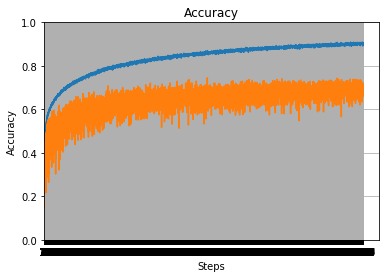

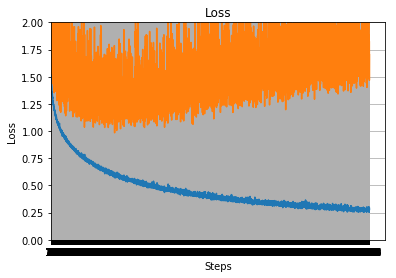

In [18]:
Plot_accuracy(history.history['acc'], history.history['val_acc'],"Accuracy")

Plot_Loss(history.history['loss'],history.history['val_loss'], "Loss")

In [19]:
predictions_resnet = model_resnet.predict(val_features_1)

In [20]:
#one hot encoding
for i in range(len(predictions_resnet)):
    length = len(predictions_resnet[i])
    index = np.argmax(predictions_resnet[i])
    predictions_resnet[i][index] = 1
    for j in range(length):
        if(j != index):
            predictions_resnet[i][j] = 0

In [21]:
print(classification_report(test_lab, predictions_resnet, target_names = dirlist_train))

             precision    recall  f1-score   support

        bed       0.84      0.65      0.73       150
      bench       0.88      0.31      0.46        70
    cabinet       0.56      0.58      0.57       150
      chair       0.82      0.85      0.83       150
      couch       0.52      0.87      0.65       150
       lamp       0.72      0.68      0.70       150
      plant       0.95      0.79      0.86       150
      table       0.72      0.71      0.72       150

avg / total       0.74      0.71      0.71      1120



------------------------------------------------------------------------------------------------------------------------------

# R-CNN : Region based CNN

https://github.com/experiencor/basic-yolo-keras

https://github.com/philipperemy/yolo-9000